In [67]:
# wrangling
import numpy as np
import pandas as pd

# geospatial data
import fiona
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster, MiniMap, Search
from shapely.geometry import Point

# others
from datetime import datetime

# original
from scripts.utils import exchange_coordinate, epsg_converter, df_2_geodf

# load data

In [68]:
probs_df = pd.read_csv("./results/y_probs.csv", index_col=0, parse_dates=True)
print(probs_df.shape)
probs_df = probs_df.stack().reset_index()
probs_df.columns = ["datetime", "geoid10", "probabiltiy"]
probs_df.head()

(15495, 195)


,datetime,geoid10,probabiltiy
0,2015-09-17 08:00:00,06075010100,0.387637
1,2015-09-17 08:00:00,06075010200,0.241744
2,2015-09-17 08:00:00,06075010300,0.098925
3,2015-09-17 08:00:00,06075010400,0.095542
4,2015-09-17 08:00:00,06075010500,0.292688


In [69]:
tracts_df = gpd.read_file('./data/census2010_ sf_tracks.geojson')
tracts_df = tracts_df.loc[tracts_df.tractce10 != "980401",
                          ['geometry', "geoid10"]]
tracts_geodf = epsg_converter(tracts_df)
tracts_geodf.head()

,geometry,geoid10
0,"(POLYGON ((-122.446471 37.775802, -122.44478 3...",06075016500
1,"(POLYGON ((-122.44034 37.77658, -122.439844 37...",06075016400
2,"(POLYGON ((-122.429152 37.778007, -122.428909 ...",06075016300
3,"(POLYGON ((-122.428909 37.778039, -122.429152 ...",06075016100
4,"(POLYGON ((-122.420425 37.780583, -122.420336 ...",06075016000


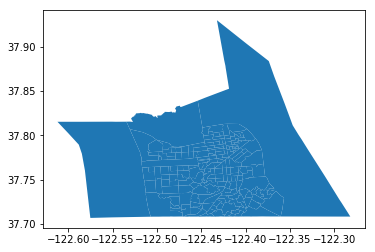

In [70]:
tracts_geodf.plot()

In [71]:
# merge
probs_df = pd.merge(probs_df, tracts_geodf, on="geoid10")
probs_geodf = gpd.GeoDataFrame(probs_df)
probs_geodf.crs = tracts_geodf.crs
probs_geodf.head()

,datetime,geoid10,probabiltiy,geometry
0,2015-09-17 08:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
1,2015-09-17 10:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
2,2015-09-17 12:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
3,2015-09-17 14:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."
4,2015-09-17 16:00:00,06075010100,0.387637,"(POLYGON ((-122.421076 37.812889, -122.420182 ..."


In [73]:
probs_2019_geodf = probs_geodf[probs_geodf["datetime"] > datetime(2019,3,31)]
probs_2019_geodf["datetime"] = probs_2019_geodf["datetime"].astype(str)

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [74]:
%%time
probs_2019_geodf.to_file("./results/probs_geodf.geojson", driver='GeoJSON')

/usr/local/var/pyenv/versions/3.7.2/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


CPU times: user 2.44 s, sys: 59.3 ms, total: 2.5 s
Wall time: 2.52 s


# mapping

In [17]:
# base map
sf_coordinates = (37.76, -122.431297)
sf_map = folium.Map(location=sf_coordinates, zoom_start=12,
                    control_scale=True, tiles="Stamen Toner")
sf_map

# scores

In [78]:
test_df = pd.read_csv("./results/test_scores.csv")
print(test_df.shape)
test_df.head()

(5, 2)


,acc,log_loss
0,0.920532,0.260748
1,0.916590,0.255125
2,0.909153,0.269369
3,0.899998,0.286154
4,0.894838,0.298277


In [79]:
test_df.mean()

acc         0.908222
log_loss    0.273935
dtype: float64